# My Filter for Collaborative RSs 

In [2]:
import numpy as np
import pandas as pd
from time import time
from numpy import save, load
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib notebook

### Variables:
* ```FADING``` - fading function.
* ```PERCENTILES``` - distribution of percentages.

In [3]:
VERSION = 3
    
if VERSION == 0:
    PERCENTILES = None
else:
    PERCENTILES = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

### Loading Data

In [4]:
data = load('../datasets/main/train_set_1M.npy')
# data = np.loadtxt('../datasets/main/ml-1M.dat', skiprows=0, delimiter='::').astype('int32')

In [5]:
data

array([[        1,         1,         5, 978824268],
       [        1,        48,         5, 978824351],
       [        1,       150,         5, 978301777],
       ...,
       [     6040,      3703,         4, 964828575],
       [     6040,      3751,         4, 964828782],
       [     6040,      3819,         5, 963272166]])

In [6]:
data_csv = pd.DataFrame(data, columns = ['user', 'item', 'rating', 'timestamp'])
data_csv.sort_values(['user', 'item'], ascending=[True, True], inplace=True)
data_csv.reset_index(inplace=True)
data_csv.drop('index', axis=1, inplace=True)
data_csv

,user,item,rating,timestamp
0,1,1,5,978824268
1,1,48,5,978824351
2,1,150,5,978301777
3,1,260,4,978300760
4,1,527,5,978824195
...,...,...,...,...
900184,6040,3671,4,997454367
900185,6040,3683,4,960971696
900186,6040,3703,4,964828575
900187,6040,3751,4,964828782


In [7]:
users = np.unique(data[:, 0]).tolist() # list of unique users
items = np.unique(data[:, 1]).tolist() # list of unique items

In [8]:
n_u = len(users)     # number of users
n_m = len(items)     # number of movies
n_r = data.shape[0]  # number of ratings

print("USERS: {}\t ITEMS: {}\t RATINGS: {}".format(n_u, n_m, n_r))

USERS: 6040	 ITEMS: 3694	 RATINGS: 900189


In [9]:
min_timestamp = min(data_csv['timestamp'])
max_timestamp = max(data_csv['timestamp'])

In [10]:
timestamp = datetime.fromtimestamp(min_timestamp)
print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))

2000-04-26 08:05:32


In [11]:
timestamp = datetime.fromtimestamp(max_timestamp)
print(timestamp.strftime('%Y-%m-%d %H:%M:%S'))

2003-03-01 02:49:50


### Timestamp Preprocessing

In [8]:
ts_desc = data_csv['timestamp'].describe(percentiles=PERCENTILES).astype('int32').tolist()[3:]

In [9]:
# [min, 25%, 50%, 75%, max]
# [min, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, max]
ts_desc 

[956703932,
 960682425,
 964152976,
 965678170,
 967588706,
 973018024,
 974688074,
 974862060,
 975767742,
 978132500,
 1046454590]

### Functions for Getting Deprocation and Updating Ratings

In [10]:
def get_fading_v0(ts):
    if ts <= ts_desc[1]:
        return 1
    elif ts_desc[1] < ts <= ts_desc[2]:
        return 0.5
    elif ts_desc[2] < ts <= ts_desc[3]:
        return 0.2
    elif ts > ts_desc[3]:
        return 0
    
# Get fading value    
def get_fading_v1(ts):
    if ts <= ts_desc[1]:
        return 1.4
    elif ts_desc[1] < ts <= ts_desc[2]:
        return 1.2
    elif ts_desc[2] < ts <= ts_desc[3]:
        return 1.0
    elif ts_desc[3] < ts <= ts_desc[4]:
        return 0.8
    elif ts_desc[4] < ts <= ts_desc[5]:
        return 0.6
    elif ts_desc[5] < ts <= ts_desc[6]:
        return 0.4
    elif ts_desc[6] < ts <= ts_desc[7]:
        return 0.2
    elif ts > ts_desc[7]:
        return 0

# Get fading value    
def get_fading_v2(ts):
    if ts <= ts_desc[1]:
        return 0.7
    elif ts_desc[1] < ts <= ts_desc[2]:
        return 0.6
    elif ts_desc[2] < ts <= ts_desc[3]:
        return 0.5
    elif ts_desc[3] < ts <= ts_desc[4]:
        return 0.4
    elif ts_desc[4] < ts <= ts_desc[5]:
        return 0.3
    elif ts_desc[5] < ts <= ts_desc[6]:
        return 0.2
    elif ts_desc[6] < ts <= ts_desc[7]:
        return 0.1
    elif ts > ts_desc[7]:
        return 0
    
# Get fading value
def get_fading_v3(ts):
    if ts <= ts_desc[1]:
        return 1.0
    elif ts_desc[1] < ts <= ts_desc[2]:
        return 0.8
    elif ts_desc[2] < ts <= ts_desc[3]:
        return 0.6
    elif ts_desc[3] < ts <= ts_desc[4]:
        return 0.4
    elif ts_desc[4] < ts <= ts_desc[5]:
        return 0.2
    elif ts_desc[5] < ts <= ts_desc[6]:
        return 0.1
    elif ts > ts_desc[6]:
        return 0

def get_updated(r, d):
    result = abs(r - d)
    if result < 1:
        return 1
    else:
        return result

In [11]:
if VERSION == 0:
    FADING = get_fading_v0
    
elif VERSION == 1:
    FADING = get_fading_v1
    
elif VERSION == 2:
    FADING = get_fading_v2
    
elif VERSION == 3:
    FADING = get_fading_v3

In [12]:
FADING

<function __main__.get_fading_v3(ts)>

In [13]:
data_csv['fading'] = data_csv['timestamp'].apply(FADING)
data_csv['updated'] = data_csv.apply(lambda x: get_updated(x['rating'], x['fading']), axis=1)
data_csv[data_csv['updated'] < 1]

,user,item,rating,timestamp,fading,updated


In [14]:
data_csv

,user,item,rating,timestamp,fading,updated
0,1,1,5,978824268,0.0,5.0
1,1,48,5,978824351,0.0,5.0
2,1,150,5,978301777,0.0,5.0
3,1,260,4,978300760,0.0,4.0
4,1,527,5,978824195,0.0,5.0
...,...,...,...,...,...,...
900184,6040,3671,4,997454367,0.0,4.0
900185,6040,3683,4,960971696,0.8,3.2
900186,6040,3703,4,964828575,0.6,3.4
900187,6040,3751,4,964828782,0.6,3.4


In [15]:
new_data_csv = data_csv[['user', 'item', 'updated']]
new_data_csv

,user,item,updated
0,1,1,5.0
1,1,48,5.0
2,1,150,5.0
3,1,260,4.0
4,1,527,5.0
...,...,...,...
900184,6040,3671,4.0
900185,6040,3683,3.2
900186,6040,3703,3.4
900187,6040,3751,3.4


In [16]:
new_data = np.array(new_data_csv)
new_data

array([[1.000e+00, 1.000e+00, 5.000e+00],
       [1.000e+00, 4.800e+01, 5.000e+00],
       [1.000e+00, 1.500e+02, 5.000e+00],
       ...,
       [6.040e+03, 3.703e+03, 3.400e+00],
       [6.040e+03, 3.751e+03, 3.400e+00],
       [6.040e+03, 3.819e+03, 4.200e+00]])

In [17]:
# Save final matrix
file = '../datasets/fading/fading_filter_{0}.0V.npy'.format(VERSION)
save(file, new_data)
data_load = load(file)

### Results

In [18]:
(new_data == data_load).all()

True

In [19]:
pd.DataFrame(data_load, columns = ['user', 'item', 'rating'])

,user,item,rating
0,1.0,1.0,5.0
1,1.0,48.0,5.0
2,1.0,150.0,5.0
3,1.0,260.0,4.0
4,1.0,527.0,5.0
...,...,...,...
900184,6040.0,3671.0,4.0
900185,6040.0,3683.0,3.2
900186,6040.0,3703.0,3.4
900187,6040.0,3751.0,3.4


### Visualization

<IPython.core.display.Javascript object>


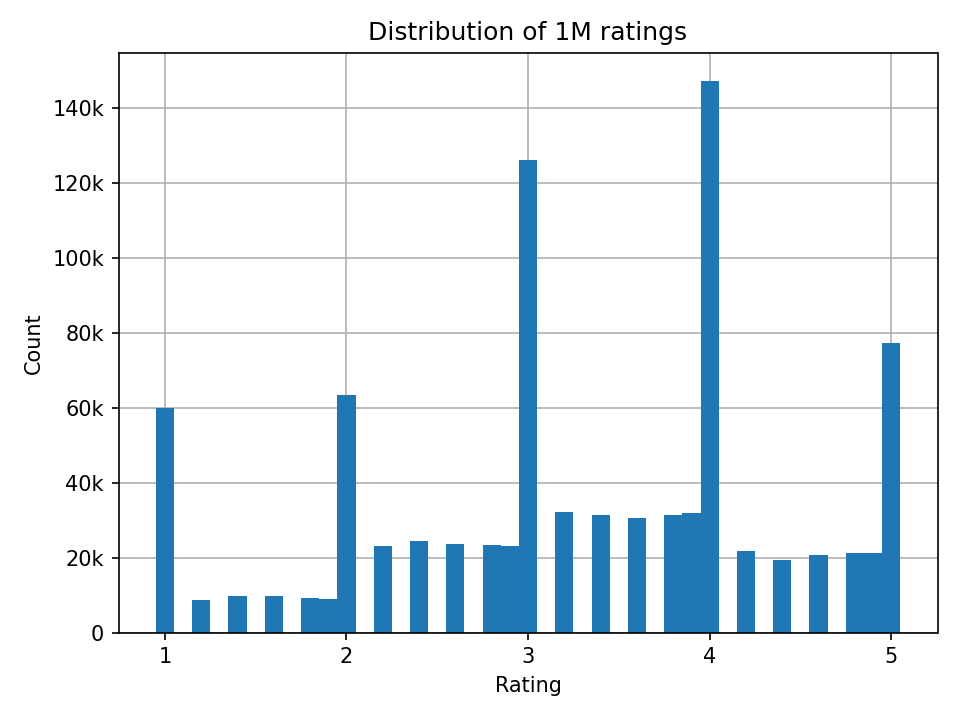

In [20]:
# Create a Figure with Axes
fig1, ax= plt.subplots()

# Coordinates 
data_rating = data_csv['updated'].value_counts().sort_index(ascending=False)

x1 = data_rating.index
y1 = data_rating.values

# Draw the bars and add the text
ax.bar(x1, y1, width=0.1, zorder=2)

# Update the yticks
locs, labels = plt.yticks()
locs_updated = ['%dk'%(round(v/1000)) if v!=0 else '0' for v in locs]
plt.yticks(ticks=locs[:-1], labels=locs_updated[:-1])

# Title and X, Y Labels
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Distribution of 1M ratings')

# Some additional functions
ax.grid(zorder=0)
fig1.tight_layout()

# Save and show figure
# fig1.savefig('./datasets/images/1. ratings bar.pdf')
fig1.show()